In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
torch.manual_seed(8) # for reproduce

import deepchem as dc
import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
torch.backends.cudnn.benchmark = True
torch.set_default_tensor_type('torch.cuda.FloatTensor')
# from tensorboardX import SummaryWriter
torch.nn.Module.dump_patches = True
import copy
import pandas as pd
#then import my own modules
from AttentiveFP import Fingerprint, Fingerprint_viz, save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight

Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. jax requires jaxlib to be installed. See https://github.com/google/jax#installation for installation instructions.


In [2]:
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

In [3]:
from rdkit import Chem
from rdkit.Chem import QED
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from IPython.display import SVG, display
import seaborn as sns; sns.set(color_codes=True)

In [4]:
task_name = 'GABAA'
tasks = ['label']
raw_filename = "attentivefp_gaba.csv"
feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename)
smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ",len(smilesList))

number of all smiles:  488


number of successfully processed smiles:  488


E:\toos\miniconda3\envs\attentivefp\lib\site-packages\ipykernel_launcher.py:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



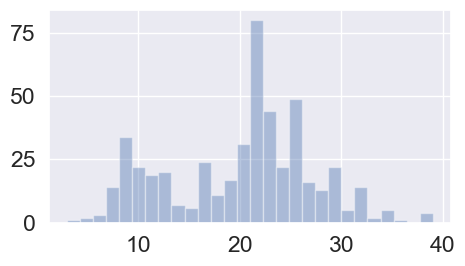

In [5]:
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print("not successfully processed smiles: ", smiles)
        pass
print("number of successfully processed smiles: ", len(remained_smiles))
smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)]

smiles_tasks_df['cano_smiles'] =canonical_smiles_list
assert canonical_smiles_list[8]==Chem.MolToSmiles(Chem.MolFromSmiles(smiles_tasks_df['cano_smiles'][8]), isomericSmiles=True)

plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.distplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()

plt.show()
plt.close()

In [6]:
random_seed = 200
random_seed = int(time.time())
start_time = str(time.ctime()).replace(':','-').replace(' ','_')
start = time.time()

batch_size = 128
epochs = 200
p_dropout = 0.1
fingerprint_dim = 150

radius = 3
T = 2
weight_decay = 2.9 # also known as l2_regularization_lambda
learning_rate = 3.5
per_task_output_units_num = 2 # for classification model with 2 classes
output_units_num = len(tasks) * per_task_output_units_num

In [7]:
if os.path.isfile(feature_filename):
    feature_dicts = pickle.load(open(feature_filename, "rb" ))
else:
    feature_dicts = save_smiles_dicts(smilesList,filename)
# feature_dicts = get_smiles_dicts(smilesList)

remained_df = smiles_tasks_df[smiles_tasks_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
uncovered_df = smiles_tasks_df.drop(remained_df.index)
uncovered_df

,smiles,label,cano_smiles


In [8]:
weights = []
for i,task in enumerate(tasks):    
    negative_df = remained_df[remained_df[task] == 0][["smiles",task]]
    positive_df = remained_df[remained_df[task] == 1][["smiles",task]]
    weights.append([(positive_df.shape[0]+negative_df.shape[0])/negative_df.shape[0],\
                    (positive_df.shape[0]+negative_df.shape[0])/positive_df.shape[0]])

In [9]:
dataset = dc.data.NumpyDataset(X=remained_df['cano_smiles'],ids=remained_df['cano_smiles'],y=remained_df['label'])
splitter = dc.splits.RandomSplitter()#ScaffoldSplitter
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset,frac_train=0.56,frac_valid=0.14,frac_test=0.3,seed=200)

In [10]:
train_df = pd.DataFrame(train_dataset.X,columns=['cano_smiles'])
train_df['label'] = train_dataset.y

In [11]:
valid_df = pd.DataFrame(valid_dataset.X,columns=['cano_smiles'])
valid_df['label'] = valid_dataset.y

In [12]:
test_df = pd.DataFrame(test_dataset.X,columns=['cano_smiles'])
test_df['label'] = test_dataset.y

In [13]:
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([canonical_smiles_list[0]],feature_dicts)
num_atom_features = x_atom.shape[-1]
num_bond_features = x_bonds.shape[-1]

loss_function = [nn.CrossEntropyLoss(torch.Tensor(weight),reduction='mean') for weight in weights]
model = Fingerprint(radius, T, num_atom_features,num_bond_features,
            fingerprint_dim, output_units_num, p_dropout)
model.cuda()
# tensorboard = SummaryWriter(log_dir="runs/"+start_time+"_"+prefix_filename+"_"+str(fingerprint_dim)+"_"+str(p_dropout))

# optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)

649206
atom_fc.weight torch.Size([150, 39])
atom_fc.bias torch.Size([150])
neighbor_fc.weight torch.Size([150, 49])
neighbor_fc.bias torch.Size([150])
GRUCell.0.weight_ih torch.Size([450, 150])
GRUCell.0.weight_hh torch.Size([450, 150])
GRUCell.0.bias_ih torch.Size([450])
GRUCell.0.bias_hh torch.Size([450])
GRUCell.1.weight_ih torch.Size([450, 150])
GRUCell.1.weight_hh torch.Size([450, 150])
GRUCell.1.bias_ih torch.Size([450])
GRUCell.1.bias_hh torch.Size([450])
GRUCell.2.weight_ih torch.Size([450, 150])
GRUCell.2.weight_hh torch.Size([450, 150])
GRUCell.2.bias_ih torch.Size([450])
GRUCell.2.bias_hh torch.Size([450])
align.0.weight torch.Size([1, 300])
align.0.bias torch.Size([1])
align.1.weight torch.Size([1, 300])
align.1.bias torch.Size([1])
align.2.weight torch.Size([1, 300])
align.2.bias torch.Size([1])
attend.0.weight torch.Size([150, 150])
attend.0.bias torch.Size([150])
attend.1.weight torch.Size([150, 150])
attend.1.bias torch.Size([150])
attend.2.weight torch.Size([150, 150])

In [14]:
def train(model, dataset, optimizer, loss_function):
    model.train()
    np.random.seed(epoch)
    valList = np.arange(0,dataset.shape[0])
    #shuffle them
    np.random.shuffle(valList)
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, train_batch in enumerate(batch_list):
        batch_df = dataset.loc[train_batch,:]
        smiles_list = batch_df.cano_smiles.values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
#         print(torch.Tensor(x_atom).size(),torch.Tensor(x_bonds).size(),torch.cuda.LongTensor(x_atom_index).size(),torch.cuda.LongTensor(x_bond_index).size(),torch.Tensor(x_mask).size())
        
        optimizer.zero_grad()
        loss = 0.0
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i * per_task_output_units_num:(i + 1) *
                                    per_task_output_units_num]
            y_val = batch_df[task].values

            validInds = np.where((y_val==0) | (y_val==1))[0]
#             validInds = np.where(y_val != -1)[0]
            if len(validInds) == 0:
                continue
            y_val_adjust = np.array([y_val[v] for v in validInds]).astype(float)
            validInds = torch.cuda.LongTensor(validInds).squeeze()
            y_pred_adjust = torch.index_select(y_pred, 0, validInds)

            loss += loss_function[i](
                y_pred_adjust,
                torch.cuda.LongTensor(y_val_adjust))
        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()



def eval(model, dataset):
    model.eval()
    y_val_list = {}
    y_pred_list = {}
    losses_list = []
    valList = np.arange(0,dataset.shape[0])
    batch_list = []
    for i in range(len(tasks)):
        y_val_list[i] = []
        y_pred_list[i] = []
    
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, eval_batch in enumerate(batch_list):
        batch_df = dataset.loc[eval_batch,:]
        smiles_list = batch_df.cano_smiles.values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        atom_pred = atoms_prediction.data[:,:,1].unsqueeze(2).cpu().numpy()
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i * per_task_output_units_num:(i + 1) *
                                    per_task_output_units_num]
            y_val = batch_df[task].values

            validInds = np.where((y_val==0) | (y_val==1))[0]
#             validInds = np.where((y_val=='0') | (y_val=='1'))[0]
#             print(validInds)
            if len(validInds) == 0:
                continue
            y_val_adjust = np.array([y_val[v] for v in validInds]).astype(float)
            validInds = torch.cuda.LongTensor(validInds).squeeze()
            y_pred_adjust = torch.index_select(y_pred, 0, validInds)
#             print(validInds)
            loss = loss_function[i](
                y_pred_adjust,
                torch.cuda.LongTensor(y_val_adjust))
#             print(y_pred_adjust)
            y_pred_adjust = F.softmax(y_pred_adjust,dim=-1).data.cpu().numpy()[:,1]
            losses_list.append(loss.cpu().detach().numpy())
        
            y_val_list[i].extend(y_val_adjust)
            y_pred_list[i].extend(y_pred_adjust)

    eval_roc = [roc_auc_score(y_val_list[i], y_pred_list[i]) for i in range(len(tasks))]

    eval_acc = [accuracy_score(y_val_list[i],
                                (np.array(y_pred_list[i]) > 0.5).astype(int)) for i in range(len(tasks))]
    
    eval_pre = [precision_score(y_val_list[i],
                                (np.array(y_pred_list[i]) > 0.5).astype(int)) for i in range(len(tasks))]
    
    eval_rec = [recall_score(y_val_list[i],
                                (np.array(y_pred_list[i]) > 0.5).astype(int)) for i in range(len(tasks))]
    
    eval_loss = np.array(losses_list).mean()
    
    return eval_roc, eval_acc, eval_pre, eval_rec, eval_loss

In [15]:
best_param ={}
best_param["auc_epoch"] = 0
best_param["loss_epoch"] = 0
best_param["valid_auc"] = 0
best_param["valid_loss"] = 9e8

for epoch in range(epochs):    
    valid_roc, valid_acc, valid_pre, valid_rec, valid_loss = eval(model, valid_df)
    valid_auc_mean = np.array(valid_roc).mean()

    if valid_auc_mean > best_param["valid_auc"]:
        best_param["auc_epoch"] = epoch
        best_param["valid_auc"] = valid_auc_mean
        if valid_auc_mean > 0.84:
             torch.save(model, 'saved_models/model1_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')             
    if valid_loss < best_param["valid_loss"]:
        best_param["loss_epoch"] = epoch
        best_param["valid_loss"] = valid_loss

    print("EPOCH:\t"+str(epoch)+'\n'\
         +"valid_auc"+":"+str(valid_roc)+'\n'\
        +"valid_acc"+":"+str(valid_acc)+'\n'\
        +"valid_pre"+":"+str(valid_pre)+'\n'\
        +"valid_rec"+":"+str(valid_rec)+'\n'\
        )
        
    torch.manual_seed(epoch)    
    train(model, train_df, optimizer, loss_function)

EPOCH:	0
valid_auc:[0.2545454545454545]
valid_acc:[0.5147058823529411]
valid_pre:[0.5147058823529411]
valid_rec:[1.0]



E:\toos\miniconda3\envs\attentivefp\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


EPOCH:	1
valid_auc:[0.6666666666666667]
valid_acc:[0.4852941176470588]
valid_pre:[0.0]
valid_rec:[0.0]

EPOCH:	2
valid_auc:[0.69004329004329]
valid_acc:[0.5]
valid_pre:[1.0]
valid_rec:[0.02857142857142857]

EPOCH:	3
valid_auc:[0.6995670995670996]
valid_acc:[0.5147058823529411]
valid_pre:[1.0]
valid_rec:[0.05714285714285714]

EPOCH:	4
valid_auc:[0.6987012987012987]
valid_acc:[0.6029411764705882]
valid_pre:[0.75]
valid_rec:[0.34285714285714286]

EPOCH:	5
valid_auc:[0.7082251082251082]
valid_acc:[0.6323529411764706]
valid_pre:[0.6785714285714286]
valid_rec:[0.5428571428571428]

EPOCH:	6
valid_auc:[0.7064935064935065]
valid_acc:[0.6470588235294118]
valid_pre:[0.6896551724137931]
valid_rec:[0.5714285714285714]

EPOCH:	7
valid_auc:[0.7125541125541125]
valid_acc:[0.6176470588235294]
valid_pre:[0.6956521739130435]
valid_rec:[0.45714285714285713]

EPOCH:	8
valid_auc:[0.7151515151515151]
valid_acc:[0.5882352941176471]
valid_pre:[0.7058823529411765]
valid_rec:[0.34285714285714286]

EPOCH:	9
valid

EPOCH:	65
valid_auc:[0.7766233766233767]
valid_acc:[0.75]
valid_pre:[0.7368421052631579]
valid_rec:[0.8]

EPOCH:	66
valid_auc:[0.7731601731601732]
valid_acc:[0.7647058823529411]
valid_pre:[0.7317073170731707]
valid_rec:[0.8571428571428571]

EPOCH:	67
valid_auc:[0.7774891774891775]
valid_acc:[0.7352941176470589]
valid_pre:[0.7297297297297297]
valid_rec:[0.7714285714285715]

EPOCH:	68
valid_auc:[0.7766233766233765]
valid_acc:[0.6911764705882353]
valid_pre:[0.7058823529411765]
valid_rec:[0.6857142857142857]

EPOCH:	69
valid_auc:[0.7818181818181817]
valid_acc:[0.7352941176470589]
valid_pre:[0.7297297297297297]
valid_rec:[0.7714285714285715]

EPOCH:	70
valid_auc:[0.7792207792207793]
valid_acc:[0.7647058823529411]
valid_pre:[0.7435897435897436]
valid_rec:[0.8285714285714286]

EPOCH:	71
valid_auc:[0.7818181818181817]
valid_acc:[0.7794117647058824]
valid_pre:[0.7380952380952381]
valid_rec:[0.8857142857142857]

EPOCH:	72
valid_auc:[0.7826839826839826]
valid_acc:[0.7794117647058824]
valid_pre:[0

EPOCH:	130
valid_auc:[0.8683982683982684]
valid_acc:[0.7647058823529411]
valid_pre:[0.7021276595744681]
valid_rec:[0.9428571428571428]

EPOCH:	131
valid_auc:[0.8536796536796537]
valid_acc:[0.75]
valid_pre:[0.8214285714285714]
valid_rec:[0.6571428571428571]

EPOCH:	132
valid_auc:[0.8606060606060606]
valid_acc:[0.7794117647058824]
valid_pre:[0.717391304347826]
valid_rec:[0.9428571428571428]

EPOCH:	133
valid_auc:[0.8632034632034632]
valid_acc:[0.7647058823529411]
valid_pre:[0.7021276595744681]
valid_rec:[0.9428571428571428]

EPOCH:	134
valid_auc:[0.8432900432900434]
valid_acc:[0.7352941176470589]
valid_pre:[0.7297297297297297]
valid_rec:[0.7714285714285715]

EPOCH:	135
valid_auc:[0.8380952380952381]
valid_acc:[0.75]
valid_pre:[0.7647058823529411]
valid_rec:[0.7428571428571429]

EPOCH:	136
valid_auc:[0.851948051948052]
valid_acc:[0.8088235294117647]
valid_pre:[0.7619047619047619]
valid_rec:[0.9142857142857143]

EPOCH:	137
valid_auc:[0.8606060606060606]
valid_acc:[0.7647058823529411]
valid

EPOCH:	193
valid_auc:[0.8744588744588744]
valid_acc:[0.8676470588235294]
valid_pre:[0.8421052631578947]
valid_rec:[0.9142857142857143]

EPOCH:	194
valid_auc:[0.8744588744588745]
valid_acc:[0.8529411764705882]
valid_pre:[0.8205128205128205]
valid_rec:[0.9142857142857143]

EPOCH:	195
valid_auc:[0.8718614718614718]
valid_acc:[0.8529411764705882]
valid_pre:[0.8205128205128205]
valid_rec:[0.9142857142857143]

EPOCH:	196
valid_auc:[0.8727272727272728]
valid_acc:[0.8529411764705882]
valid_pre:[0.8205128205128205]
valid_rec:[0.9142857142857143]

EPOCH:	197
valid_auc:[0.8753246753246754]
valid_acc:[0.8382352941176471]
valid_pre:[0.7857142857142857]
valid_rec:[0.9428571428571428]

EPOCH:	198
valid_auc:[0.870995670995671]
valid_acc:[0.8235294117647058]
valid_pre:[0.8484848484848485]
valid_rec:[0.8]

EPOCH:	199
valid_auc:[0.870995670995671]
valid_acc:[0.8382352941176471]
valid_pre:[0.8157894736842105]
valid_rec:[0.8857142857142857]



In [16]:
best_model = torch.load('saved_models/model1_'+prefix_filename+'_'+start_time+'_'+str(best_param["auc_epoch"])+'.pt')   

best_model_dict = best_model.state_dict()
best_model_wts = copy.deepcopy(best_model_dict)

model.load_state_dict(best_model_wts)
(best_model.align[0].weight == model.align[0].weight).all()
test_auc, test_acc, test_pre, test_rec, test_loss = eval(model, test_df)
print("best epoch:"+str(best_param["auc_epoch"])+"\n"
          +"test_auc"+":"+str(test_auc)+'\n'\
        +"test_acc"+":"+str(test_acc)+'\n'\
        +"test_pre"+":"+str(test_pre)+'\n'\
        +"test_rec"+":"+str(test_rec)+'\n'\
     )

best epoch:162
test_auc:[0.8367003367003366]
test_acc:[0.7687074829931972]
test_pre:[0.7526881720430108]
test_rec:[0.8641975308641975]

